In [15]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
from matplotlib.offsetbox import OffsetImage

from PIL import Image
import numpy as np
from io import BytesIO
import requests
# ML Libraryies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import plotly.express as px

# Graphing 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

In [16]:
# import data
weekly_nfl = nfl.import_weekly_data([2023])
weekly_nfl.dtypes

Downcasting floats.


player_id                       object
player_name                     object
player_display_name             object
position                        object
position_group                  object
headshot_url                    object
recent_team                     object
season                           int32
week                             int32
season_type                     object
opponent_team                   object
completions                      int32
attempts                         int32
passing_yards                  float32
passing_tds                      int32
interceptions                  float32
sacks                          float32
sack_yards                     float32
sack_fumbles                     int32
sack_fumbles_lost                int32
passing_air_yards              float32
passing_yards_after_catch      float32
passing_first_downs            float32
passing_epa                    float32
passing_2pt_conversions          int32
pacr                     

In [17]:
### RB stats
# gather RB stats
rb_df_two = weekly_nfl[(weekly_nfl["position"] == "RB")]
new_columns = ['week','player_display_name','recent_team', 'opponent_team','fantasy_points', 'fantasy_points_ppr','completions','attempts','passing_yards','passing_epa','receptions','passing_tds','targets','rushing_tds','rushing_fumbles','rushing_epa','rushing_yards','carries']
rb_df = rb_df_two[new_columns]
rb_df.head()

,week,player_display_name,recent_team,opponent_team,fantasy_points,fantasy_points_ppr,completions,attempts,passing_yards,passing_epa,receptions,passing_tds,targets,rushing_tds,rushing_fumbles,rushing_epa,rushing_yards,carries
122,1,Latavius Murray,BUF,NYJ,1.7,2.7,0,0,0.0,NaN,1,0,2,0,0.0,-0.030657,8.0,2
123,2,Latavius Murray,BUF,LV,9.1,11.1,0,0,0.0,NaN,2,0,2,1,0.0,-0.385805,22.0,6
124,3,Latavius Murray,BUF,WAS,8.1,9.1,0,0,0.0,NaN,1,0,1,1,0.0,2.809970,15.0,5
125,4,Latavius Murray,BUF,MIA,5.6,7.6,0,0,0.0,NaN,2,0,2,0,0.0,0.880046,32.0,4
126,5,Latavius Murray,BUF,JAX,0.7,1.7,0,0,0.0,NaN,1,0,1,0,0.0,-0.370126,6.0,2


In [18]:
## Groupby opponent team and get mean

# Groupby opponent and week offense stats
team_by_week = rb_df.groupby(['week', 'opponent_team'])
team_by_week.head()
team_stats_per_game = team_by_week.sum()
team_stats_per_game.index.set_names(['week', 'team_defense'], inplace=True)
team_stats_per_game = team_stats_per_game.reset_index()
team_stats_per_game.head()

,week,team_defense,fantasy_points,fantasy_points_ppr,completions,attempts,passing_yards,passing_epa,receptions,passing_tds,targets,rushing_tds,rushing_fumbles,rushing_epa,rushing_yards,carries
0,1,ARI,13.200001,15.200001,0,0,0.0,0.0,2,0,3,0,1.0,-8.665813,75.0,25
1,1,ATL,14.700001,20.700001,0,0,0.0,0.0,6,0,8,0,1.0,-6.410028,132.0,27
2,1,BAL,8.000000,13.000000,0,0,0.0,0.0,5,0,7,0,0.0,-6.427449,53.0,18
3,1,BUF,22.400000,28.400000,0,0,0.0,0.0,6,0,7,0,1.0,0.625138,166.0,24
4,1,CAR,35.700001,44.699997,0,0,0.0,0.0,9,0,9,2,0.0,-0.595772,131.0,25


In [19]:
# get mean of defense

team_rb_mean = team_stats_per_game.groupby('team_defense').mean()
team_rb_mean.columns = [col + '_def' for col in team_rb_mean.columns]
team_rb_mean = team_rb_mean.drop('week_def', axis=1)
team_rb_mean = team_rb_mean.reset_index()
team_rb_mean.head()
team_rb_mean.to_excel('rb_def.xlsx', index=True)

In [20]:
# get mean of team rb stats
# Groupby opponent and week offense stats
team_rb = rb_df.groupby(['week', 'recent_team'])
team_rb.head()
team_stats_rb= team_rb.sum()
team_stats_rb.index.set_names(['week', 'team_rb'], inplace=True)

team_stats_rb = team_stats_rb.reset_index()
team_stats_rb.head()

,week,team_rb,fantasy_points,fantasy_points_ppr,completions,attempts,passing_yards,passing_epa,receptions,passing_tds,targets,rushing_tds,rushing_fumbles,rushing_epa,rushing_yards,carries
0,1,ARI,6.600000,11.600000,0,0,0.0,0.0,5,0,5,0,0.0,-5.065811,58.0,19
1,1,ATL,35.700001,44.699997,0,0,0.0,0.0,9,0,9,2,0.0,-0.595772,131.0,25
2,1,BAL,27.799999,29.799999,0,0,0.0,0.0,2,0,3,3,0.0,-2.376849,63.0,24
3,1,BUF,9.900001,16.900000,0,0,0.0,0.0,7,0,10,0,0.0,-1.665931,57.0,15
4,1,CAR,14.700001,20.700001,0,0,0.0,0.0,6,0,8,0,1.0,-6.410028,132.0,27


In [21]:
# get mean of rb

team_rb_df = team_stats_rb.groupby('team_rb').mean()
team_rb_df = team_rb_df.drop('week', axis=1)
team_rb_df = team_rb_df.reset_index()
team_rb_df.head()
team_rb_df.to_excel('rb_offense.xlsx', index=True)

In [22]:
# get team logo
# Get NFL Logos for DF
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logo_paths = []
team_abbr = []
if not os.path.exists("logos"):
    os.makedirs("logos")

for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
logo_data = pd.DataFrame(data)

team_rb_df = pd.merge(team_rb_df, logo_data, left_on = 'team_rb', right_on = 'team_abbr')
team_rb_mean = pd.merge(team_rb_mean, logo_data, left_on = 'team_defense', right_on = 'team_abbr')

In [23]:
team_rb_mean.head()

,team_defense,fantasy_points_def,fantasy_points_ppr_def,completions_def,attempts_def,passing_yards_def,passing_epa_def,receptions_def,passing_tds_def,targets_def,rushing_tds_def,rushing_fumbles_def,rushing_epa_def,rushing_yards_def,carries_def,team_abbr,logo_path
0,ARI,21.845455,26.481819,0.0,0.0,0.0,0.000000,4.636364,0.0,5.363636,1.000000,0.090909,-1.337660,110.545456,26.363636,ARI,logos/ARI.tif
1,ATL,12.460000,15.760000,0.0,0.0,0.0,-0.151879,3.300000,0.0,4.200000,0.000000,0.100000,-3.826893,82.500000,21.600000,ATL,logos/ATL.tif
2,BAL,14.490909,18.763636,0.0,0.0,0.0,0.000000,4.272727,0.0,5.000000,0.272727,0.000000,-2.426352,87.000000,20.090909,BAL,logos/BAL.tif
3,BUF,17.263636,23.081818,0.0,0.0,0.0,0.000000,5.818182,0.0,7.545455,0.545455,0.272727,-2.633430,85.181816,19.363636,BUF,logos/BUF.tif
4,CAR,23.670000,28.270000,0.0,0.0,0.0,0.000000,4.600000,0.0,6.000000,1.300000,0.000000,1.632809,114.699997,24.800000,CAR,logos/CAR.tif


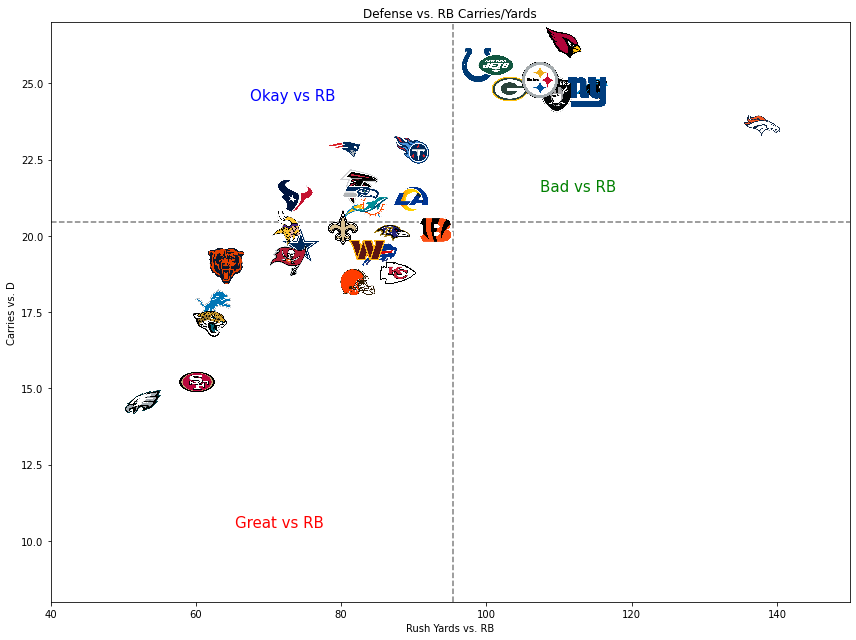

In [24]:
# create graph for D vs RB

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.08)

y = team_rb_mean['carries_def']
x = team_rb_mean['rushing_yards_def']
paths = team_rb_mean['logo_path']

fig, ax = plt.subplots()

# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)

plt.title("Defense vs. RB Carries/Yards")
plt.ylabel("Carries vs. D")
plt.xlabel("Rush Yards vs. RB")
plt.grid(False)
plt.xlim(40, 150)
plt.ylim(8, 27)
# Quadrant 1 
plt.text(x_mid + 12, y_mid + 1, 'Bad vs RB', fontsize=15, color='green')

# Quadrant 2 
plt.text(x_mid - 28, y_mid + 4, 'Okay vs RB', fontsize=15, color='blue')

# Quadrant 3 
plt.text(x_mid - 30, y_mid - 10, 'Great vs RB', fontsize=15, color='red')

# Quadrant 4 
#plt.text(x_mid + 30, y_mid - 10, 'Good vs RB', fontsize=15, color='orange')

plt.savefig('D_vs.png')
plt.show()

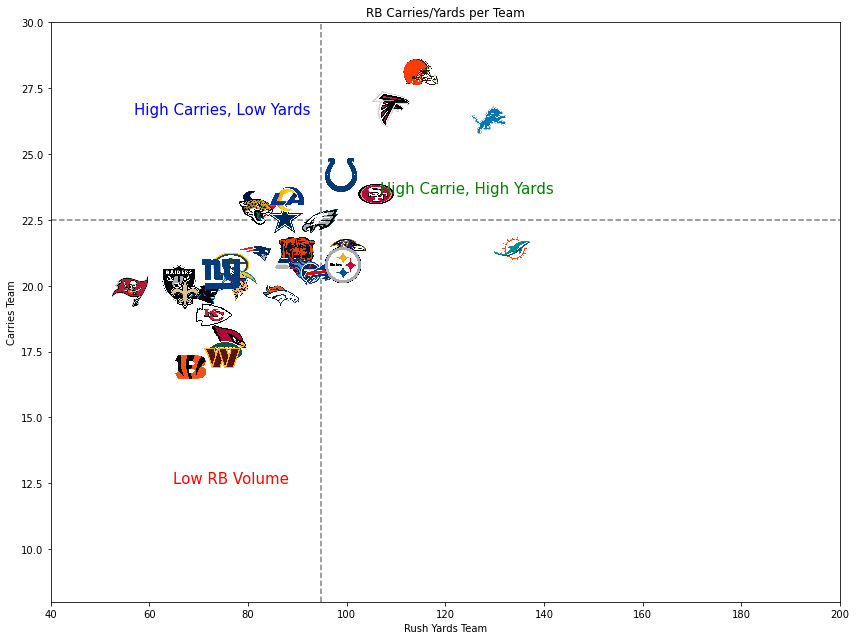

In [25]:
# create graph for RB team

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.08)

y = team_rb_df['carries']
x = team_rb_df['rushing_yards']
paths = team_rb_df['logo_path']

fig, ax = plt.subplots()

# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)

plt.title("RB Carries/Yards per Team")
plt.ylabel("Carries Team")
plt.xlabel("Rush Yards Team")
plt.grid(False)
plt.xlim(40, 200)
plt.ylim(8, 30)
# Quadrant 1 
plt.text(x_mid + 12, y_mid + 1, 'High Carrie, High Yards', fontsize=15, color='green')

# Quadrant 2 
plt.text(x_mid - 38, y_mid + 4, 'High Carries, Low Yards', fontsize=15, color='blue')

# Quadrant 3 
plt.text(x_mid - 30, y_mid - 10, 'Low RB Volume', fontsize=15, color='red')

# Quadrant 4 
#plt.text(x_mid + 30, y_mid - 10, 'Good vs RB', fontsize=15, color='orange')

plt.savefig('RB_vs_D.png')
plt.show()

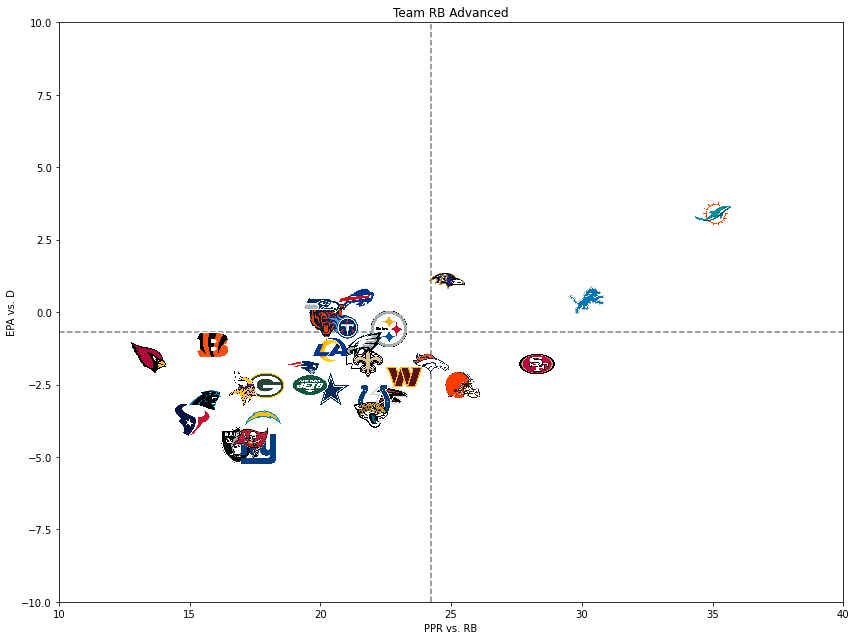

In [26]:
# create graph for D vs RB

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.08)

y = team_rb_df['rushing_epa']
x = team_rb_df['fantasy_points_ppr']
paths = team_rb_df['logo_path']

fig, ax = plt.subplots()

# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)

plt.title("Team RB Advanced")
plt.ylabel("EPA vs. D")
plt.xlabel("PPR vs. RB")
plt.grid(False)
plt.xlim(10, 40)
plt.ylim(-10, 10)
# Quadrant 1 
#plt.text(x_mid + 3, y_mid + 10, 'Bad vs TE', fontsize=15, color='green')

# Quadrant 2 
#plt.text(x_mid - 3, y_mid + 10, 'Okay vs TE', fontsize=15, color='blue')

# Quadrant 3 
#plt.text(x_mid - 3, y_mid - 10, 'Great vs TE', fontsize=15, color='red')

# Quadrant 4 
#plt.text(x_mid + 3, y_mid - 10, 'Good vs TE', fontsize=15, color='orange')

#plt.savefig('TE_vs_D.png')
plt.show()

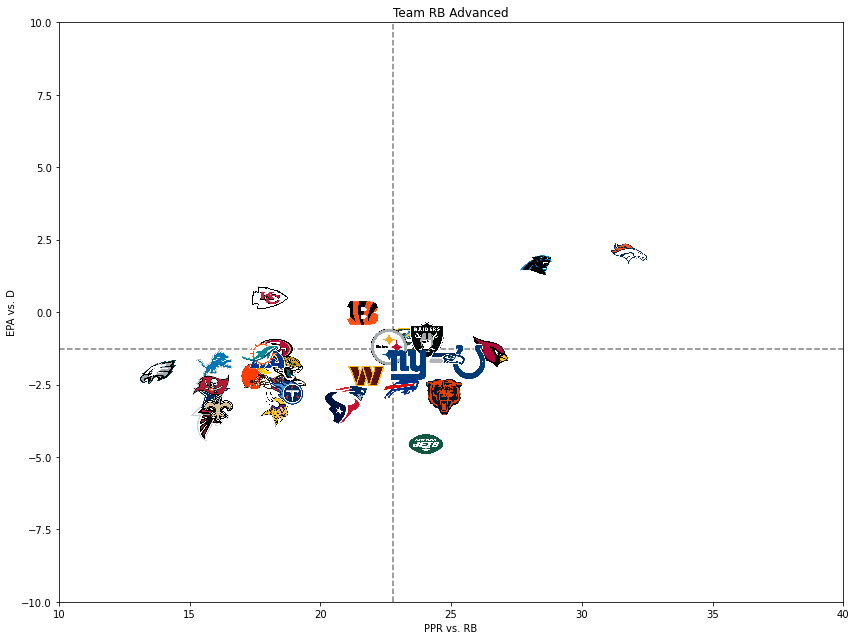

In [27]:
# create graph for D vs RB

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.08)

y = team_rb_mean['rushing_epa_def']
x = team_rb_mean['fantasy_points_ppr_def']
paths = team_rb_mean['logo_path']

fig, ax = plt.subplots()

# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

        
plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)

plt.title("Team RB Advanced")
plt.ylabel("EPA vs. D")
plt.xlabel("PPR vs. RB")
plt.grid(False)
plt.xlim(10, 40)
plt.ylim(-10, 10)
# Quadrant 1 
#plt.text(x_mid + 3, y_mid + 10, 'Bad vs TE', fontsize=15, color='green')

# Quadrant 2 
#plt.text(x_mid - 3, y_mid + 10, 'Okay vs TE', fontsize=15, color='blue')

# Quadrant 3 
#plt.text(x_mid - 3, y_mid - 10, 'Great vs TE', fontsize=15, color='red')

# Quadrant 4 
#plt.text(x_mid + 3, y_mid - 10, 'Good vs TE', fontsize=15, color='orange')

#plt.savefig('TE_vs_D.png')
plt.show()

In [28]:
#merge player
team_rb_mean.head()

,team_defense,fantasy_points_def,fantasy_points_ppr_def,completions_def,attempts_def,passing_yards_def,passing_epa_def,receptions_def,passing_tds_def,targets_def,rushing_tds_def,rushing_fumbles_def,rushing_epa_def,rushing_yards_def,carries_def,team_abbr,logo_path
0,ARI,21.845455,26.481819,0.0,0.0,0.0,0.000000,4.636364,0.0,5.363636,1.000000,0.090909,-1.337660,110.545456,26.363636,ARI,logos/ARI.tif
1,ATL,12.460000,15.760000,0.0,0.0,0.0,-0.151879,3.300000,0.0,4.200000,0.000000,0.100000,-3.826893,82.500000,21.600000,ATL,logos/ATL.tif
2,BAL,14.490909,18.763636,0.0,0.0,0.0,0.000000,4.272727,0.0,5.000000,0.272727,0.000000,-2.426352,87.000000,20.090909,BAL,logos/BAL.tif
3,BUF,17.263636,23.081818,0.0,0.0,0.0,0.000000,5.818182,0.0,7.545455,0.545455,0.272727,-2.633430,85.181816,19.363636,BUF,logos/BUF.tif
4,CAR,23.670000,28.270000,0.0,0.0,0.0,0.000000,4.600000,0.0,6.000000,1.300000,0.000000,1.632809,114.699997,24.800000,CAR,logos/CAR.tif
